In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## Data Cleaning

In [3]:
# Replacing white space with nan

df = df.replace('', np.nan)

In [4]:
# Checking which columns are empty and removing

nan_col = df.columns[df.isna().all()].tolist()
df.drop(columns=nan_col, inplace=True)

print("Empty columns that were removed:")
print(nan_col)

Empty columns that were removed:
['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [5]:
# Account Number and Customer Id columns appear to be equal

df['accountNumber'].equals(df['customerId'])

True

In [6]:
# Removing customerId as it is a duplicate of accountNumber

df.drop(columns=['customerId'], inplace=True)

In [7]:
# Dropping merchantName as merchantCategory will be used
df.drop(columns=['merchantName'], inplace=True)

In [8]:
# Need to remove remaining unneeded columns
#df.drop(columns=['cardCVV'], inplace=True)
#df.drop(columns=['enteredCVV'], inplace=True)
df.drop(columns=['cardLast4Digits'], inplace=True)

In [9]:
# Filling NaN with purchase to keep data

df['transactionType'] = df['transactionType'].fillna('PURCHASE')

In [10]:
# Total amount of rows with NaN values
df.isnull().any(axis=1).sum()

9003

In [11]:
# Dropping all rows with NaN value
df = df.dropna()

In [12]:
pd.pandas.set_option('display.max_columns', None)

In [13]:
# Changing transactionDatetime. All transactions occurred in 2016, year is unneeded.

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['Month'] = df['transactionDateTime'].dt.month
df['day'] = df['transactionDateTime'].dt.day
df['hour'] = df['transactionDateTime'].dt.hour
df['minute'] = df['transactionDateTime'].dt.minute

# Cyclic encoding for hour and minute
df['hourSin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hourCos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minuteSin'] = np.sin(2 * np.pi * df['minute'] / 24)
df['minuteCos'] = np.cos(2 * np.pi * df['minute'] / 24)

# Do not need columns
df.drop(columns=['transactionDateTime'], inplace=True)
df.drop(columns=['hour'], inplace=True)
df.drop(columns=['minute'], inplace=True)

In [14]:
# Reformatting other date columns

df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month

df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year
df['accountOpenMonth'] = pd.to_datetime(df['accountOpenDate']).dt.month
df['accountOpenDay'] = pd.to_datetime(df['accountOpenDate']).dt.day

df['lastAddressChangeYear'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.year
df['lastAddressChangeMonth'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.month
df['lastAddressChangeDay'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.day

# removing unneeded columns
df.drop(columns=['currentExpDate'], inplace=True)
df.drop(columns=['accountOpenDate'], inplace=True)
df.drop(columns=['dateOfLastAddressChange'], inplace=True)

## Encoding

In [15]:
# Categorical columns that need to be endocded

columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantCategoryCode']
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Convert boolean columns to integers
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777360 entries, 0 to 786362
Data columns (total 62 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   accountNumber                              777360 non-null  int64  
 1   creditLimit                                777360 non-null  int64  
 2   availableMoney                             777360 non-null  float64
 3   transactionAmount                          777360 non-null  float64
 4   cardCVV                                    777360 non-null  int64  
 5   enteredCVV                                 777360 non-null  int64  
 6   currentBalance                             777360 non-null  float64
 7   cardPresent                                777360 non-null  int32  
 8   expirationDateKeyInMatch                   777360 non-null  int32  
 9   isFraud                                    777360 non-null  bool   
 10  Month   

In [17]:
# Breaking apart features and labels

features = df.iloc[:, :-1]
labels = df['isFraud']

## Splitting dataset into train, test and val

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

np.random.seed(33)
tf.random.set_seed(33)

X = df.drop('isFraud', axis = 1)
Y = df['isFraud']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=33, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)


In [19]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize your numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

#Fit your instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.fit_transform(x_test) #Transform your test data instance features_test
x_val_scaled = ct.fit_transform(x_val)

## Testing Function

In [20]:
# Function to test the model and produce results
'''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):

    #predict probabilities
    y_pred = model.predict(x_test)

    #Convert probs intobinary predictions
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)

    #Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    #Print metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc)
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)
'''

'\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay\n\ndef test_metrics(model, x_test, y_test):\n\n    #predict probabilities\n    y_pred = model.predict(x_test)\n\n    #Convert probs intobinary predictions\n    threshold = 0.5\n    y_pred_binary = (y_pred >= threshold).astype(int)\n\n    #Calculate metrics\n    accuracy = accuracy_score(y_test, y_pred_binary)\n    precision = precision_score(y_test, y_pred_binary)\n    recall = recall_score(y_test, y_pred_binary)\n    f1 = f1_score(y_test, y_pred_binary)\n\n    # ROC and AUC\n    fpr, tpr, _ = roc_curve(y_test, y_pred)\n    auc = roc_auc_score(y_test, y_pred)\n\n    #Confusion Matrix\n    cm = confusion_matrix(y_test, y_pred_binary)\n\n    #Print metrics\n    print("Accuracy:", accuracy)\n    print("Precision:", precision)\n    print("Recall:", recall)\n    print("F1-Score:", f1)\n    print("AUC:", auc)\n    print("Confusion Matrix:"

In [21]:
# Function to test the model and produce results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Find the best threshold for F1 score
    thresholds = np.linspace(0, 1, 100)  # Generates 100 points between 0 and 1
    f1_scores = []
    for thresh in thresholds:
        y_pred_binary = (y_pred >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred_binary)
        f1_scores.append(f1)
    
    # Get the best threshold
    max_f1_index = np.argmax(f1_scores)  # Index of the highest F1 score
    best_threshold = thresholds[max_f1_index]
    best_f1 = f1_scores[max_f1_index]

    # Use the best threshold to get final predictions
    y_pred_binary = (y_pred >= best_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred_binary)

    # Print metrics
    print(f"Best Threshold: {best_threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {best_f1}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

    metrics = {
        'Best Threshold': best_threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': best_f1,
        'AUC': auc,
        'Confusion Matrix': cm
    }
    return metrics

## Model Creation

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(33)
tf.random.set_seed(33)

model_1 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
model_1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [24]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_1.fit(x_train_scaled, y_train, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
17005/17005 [==============================] - 17s 949us/step - loss: 0.0741 - binary_accuracy: 0.9845 - recall: 0.0000e+00 - val_loss: 0.0719 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 2/10
17005/17005 [==============================] - 16s 931us/step - loss: 0.0715 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0721 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 3/10
17005/17005 [==============================] - 16s 918us/step - loss: 0.0705 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0705 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 4/10
17005/17005 [==============================] - 16s 937us/step - loss: 0.0700 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0710 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 5/10
17005/17005 [==============================] - 16s 924us/step - loss: 0.0696 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0704 - val_bina

3644/3644 [==============================] - 2s 518us/step
Best Threshold: 0.07070707070707072
Accuracy: 0.9535693458200405
Precision: 0.09459762385115444
Recall: 0.23483583750695602
F1-Score: 0.13486736976669864
AUC: 0.7920976317666979
Confusion Matrix:
[[110768   4039]
 [  1375    422]]


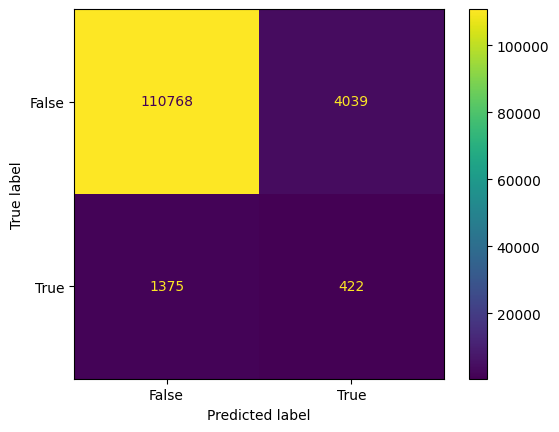

In [25]:
m1_test_results = test_metrics(model_1, x_test_scaled, y_test)

## Model Creation with SMOTE

In [26]:
np.random.seed(33)
tf.random.set_seed(33)
# Applying SMOTE to address the class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=33)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [27]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize your numerical features

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

#Fit your instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train_resampled)
x_test_scaled = ct.fit_transform(x_test) #Transform your test data instance features_test
x_val_scaled = ct.fit_transform(x_val)

In [28]:
np.random.seed(33)
tf.random.set_seed(33)

model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [29]:
model_2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [30]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_2.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 30s 883us/step - loss: 0.1094 - binary_accuracy: 0.9597 - recall_1: 0.9401 - val_loss: 0.5239 - val_binary_accuracy: 0.7799 - val_recall_1: 0.4853
Epoch 2/10
33486/33486 [==============================] - 30s 881us/step - loss: 0.0780 - binary_accuracy: 0.9737 - recall_1: 0.9578 - val_loss: 0.7590 - val_binary_accuracy: 0.7066 - val_recall_1: 0.5754
Epoch 3/10
33486/33486 [==============================] - 30s 881us/step - loss: 0.0714 - binary_accuracy: 0.9764 - recall_1: 0.9618 - val_loss: 1.0112 - val_binary_accuracy: 0.6598 - val_recall_1: 0.6316
Epoch 4/10
33486/33486 [==============================] - 30s 883us/step - loss: 0.0675 - binary_accuracy: 0.9781 - recall_1: 0.9642 - val_loss: 0.9931 - val_binary_accuracy: 0.6407 - val_recall_1: 0.6244
Epoch 5/10
33486/33486 [==============================] - 30s 906us/step - loss: 0.0646 - binary_accuracy: 0.9792 - recall_1: 0.9660 - val_loss: 1.1325 - val_binary_accuracy: 0.637

3644/3644 [==============================] - 2s 540us/step
Best Threshold: 0.98989898989899
Accuracy: 0.8296284861582793
Precision: 0.03293180995709042
Recall: 0.3544796883695047
F1-Score: 0.06026490066225165
AUC: 0.6788108992033709
Confusion Matrix:
[[96101 18706]
 [ 1160   637]]


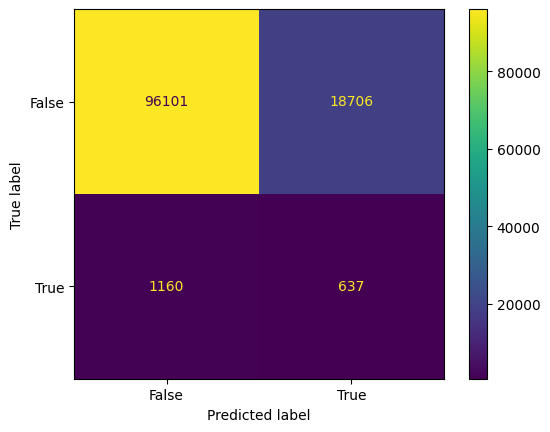

In [31]:
m2_test_results = test_metrics(model_2, x_test_scaled, y_test)

## Model 3
Using precision as a metric and SMOTE since it improved True positive rate

In [32]:
np.random.seed(33)
tf.random.set_seed(33)

model_3 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [33]:
model_3.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [34]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_3.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 31s 901us/step - loss: 0.1136 - binary_accuracy: 0.9584 - recall_2: 0.9386 - precision: 0.9772 - val_loss: 0.5121 - val_binary_accuracy: 0.7768 - val_recall_2: 0.5147 - val_precision: 0.0355
Epoch 2/10
33486/33486 [==============================] - 30s 887us/step - loss: 0.0804 - binary_accuracy: 0.9726 - recall_2: 0.9563 - precision: 0.9884 - val_loss: 0.6310 - val_binary_accuracy: 0.7340 - val_recall_2: 0.5270 - val_precision: 0.0304
Epoch 3/10
33486/33486 [==============================] - 30s 881us/step - loss: 0.0730 - binary_accuracy: 0.9757 - recall_2: 0.9608 - precision: 0.9903 - val_loss: 0.9981 - val_binary_accuracy: 0.6289 - val_recall_2: 0.6544 - val_precision: 0.0268
Epoch 4/10
33486/33486 [==============================] - 29s 880us/step - loss: 0.0686 - binary_accuracy: 0.9774 - recall_2: 0.9634 - precision: 0.9911 - val_loss: 1.1556 - val_binary_accuracy: 0.5788 - val_recall_2: 0.6789 - val_precision: 0.0245
Epoc

3644/3644 [==============================] - 2s 521us/step
Best Threshold: 0.98989898989899
Accuracy: 0.8323556653288052
Precision: 0.035873032473984205
Recall: 0.3817473567056205
F1-Score: 0.06558317399617591
AUC: 0.6892028333011461
Confusion Matrix:
[[96370 18437]
 [ 1111   686]]


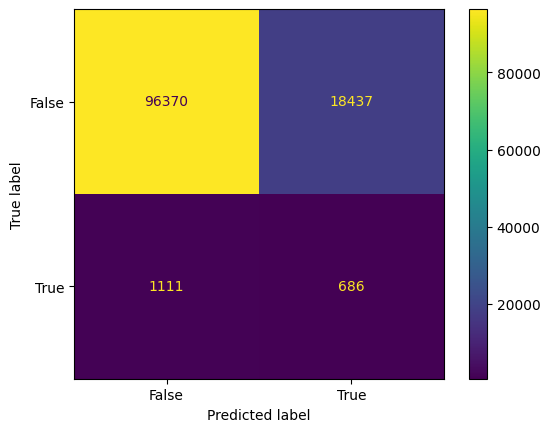

In [35]:
m3_test_results = test_metrics(model_3, x_test_scaled, y_test)

## Model 4
Model architecture changes.  
With SMOTE  
Adding two more hidden layers.  
Adding dropout layers  
Adding regularization to hidden layers.

In [36]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

np.random.seed(33)
tf.random.set_seed(33)

model_4 = Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1), input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model_4.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [38]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_4.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 45s 1ms/step - loss: 0.7382 - binary_accuracy: 0.4995 - recall_3: 0.5041 - precision_1: 0.4995 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 44s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_3: 0.5265 - precision_1: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 44s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4998 - recall_3: 0.4784 - precision_1: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_precision_1: 0.0154
Epoch 4/10
33486/33486 [==============================] - 44s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4992 - recall_3: 0.5338 - precision_1: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_

3644/3644 [==============================] - 2s 574us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


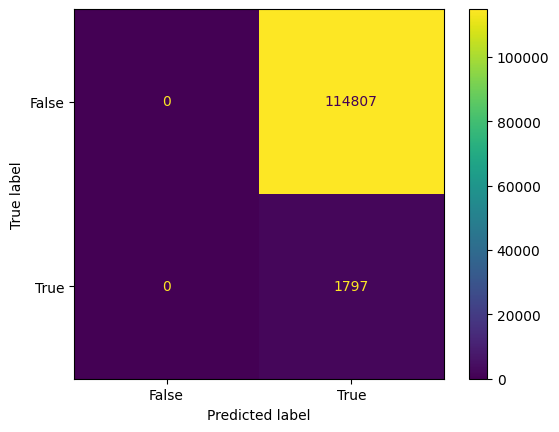

In [39]:
m4_test_results = test_metrics(model_4, x_test_scaled, y_test)

## Model 5
Previous model had too many changes.  
Reverting back to Model 3 arcitechture with only adding dropout layers.


In [40]:
np.random.seed(33)
tf.random.set_seed(33)

model_5 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
model_5.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [42]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_5.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1447 - binary_accuracy: 0.9435 - recall_4: 0.9190 - precision_2: 0.9663 - val_loss: 0.2376 - val_binary_accuracy: 0.9080 - val_recall_4: 0.2721 - val_precision_2: 0.0494
Epoch 2/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1092 - binary_accuracy: 0.9603 - recall_4: 0.9389 - precision_2: 0.9809 - val_loss: 0.2140 - val_binary_accuracy: 0.9208 - val_recall_4: 0.2565 - val_precision_2: 0.0552
Epoch 3/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1020 - binary_accuracy: 0.9637 - recall_4: 0.9428 - precision_2: 0.9839 - val_loss: 0.2881 - val_binary_accuracy: 0.8789 - val_recall_4: 0.3484 - val_precision_2: 0.0461
Epoch 4/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.0982 - binary_accuracy: 0.9653 - recall_4: 0.9453 - precision_2: 0.9848 - val_loss: 0.2709 - val_binary_accuracy: 0.8859 - val_recall_4: 0.3239 - val_precision_2: 0.0

3644/3644 [==============================] - 2s 579us/step
Best Threshold: 0.8585858585858587
Accuracy: 0.9559449075503413
Precision: 0.06167979002624672
Recall: 0.13077351140790205
F1-Score: 0.08382379168896023
AUC: 0.7187855164966581
Confusion Matrix:
[[111232   3575]
 [  1562    235]]


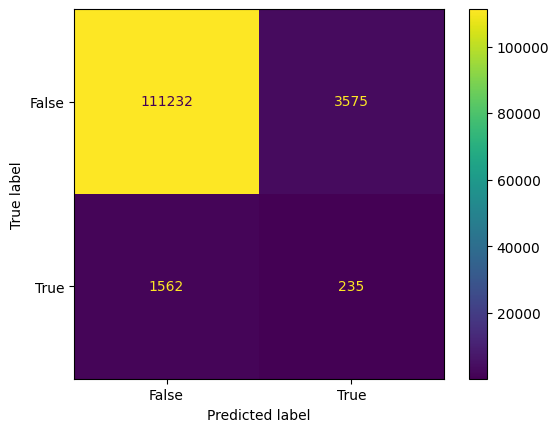

In [43]:
m5_test_results = test_metrics(model_5, x_test_scaled, y_test)

## Model 6
Adding an additional layer to model 3 arcitechture

In [44]:
np.random.seed(33)
tf.random.set_seed(33)

model_6 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model_6.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [46]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_6.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 32s 938us/step - loss: 0.1075 - binary_accuracy: 0.9606 - recall_5: 0.9399 - precision_3: 0.9806 - val_loss: 0.8717 - val_binary_accuracy: 0.6689 - val_recall_5: 0.5882 - val_precision_3: 0.0272
Epoch 2/10
33486/33486 [==============================] - 31s 921us/step - loss: 0.0787 - binary_accuracy: 0.9733 - recall_5: 0.9566 - precision_3: 0.9896 - val_loss: 1.0116 - val_binary_accuracy: 0.6675 - val_recall_5: 0.5965 - val_precision_3: 0.0274
Epoch 3/10
33486/33486 [==============================] - 31s 928us/step - loss: 0.0721 - binary_accuracy: 0.9760 - recall_5: 0.9609 - precision_3: 0.9908 - val_loss: 1.0954 - val_binary_accuracy: 0.6590 - val_recall_5: 0.6199 - val_precision_3: 0.0277
Epoch 4/10
33486/33486 [==============================] - 30s 910us/step - loss: 0.0684 - binary_accuracy: 0.9775 - recall_5: 0.9633 - precision_3: 0.9915 - val_loss: 1.7198 - val_binary_accuracy: 0.5329 - val_recall_5: 0.7145 - val_precisio

3644/3644 [==============================] - 2s 513us/step
Best Threshold: 0.98989898989899
Accuracy: 0.8600905629309458
Precision: 0.033005211349160395
Recall: 0.2854757929883139
F1-Score: 0.05916955017301038
AUC: 0.6771529232488646
Confusion Matrix:
[[99777 15030]
 [ 1284   513]]


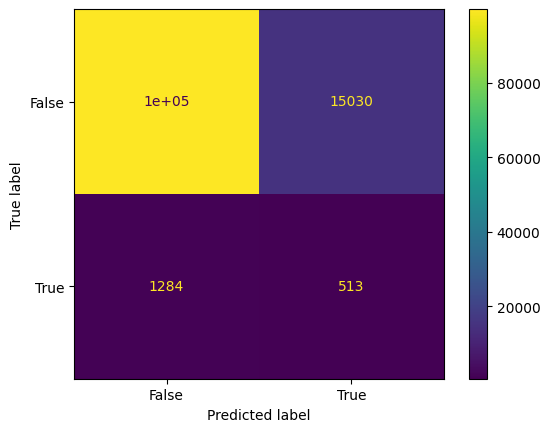

In [47]:
m6_test_results = test_metrics(model_6, x_test_scaled, y_test)

## Model 7
Attempt leakly Relu activation

In [48]:
np.random.seed(33)
tf.random.set_seed(33)

model_7 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(32),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
model_7.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [50]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_7.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 30s 894us/step - loss: 0.1122 - binary_accuracy: 0.9583 - recall_6: 0.9377 - precision_4: 0.9780 - val_loss: 0.6010 - val_binary_accuracy: 0.7491 - val_recall_6: 0.5403 - val_precision_4: 0.0330
Epoch 2/10
33486/33486 [==============================] - 30s 907us/step - loss: 0.0797 - binary_accuracy: 0.9729 - recall_6: 0.9564 - precision_4: 0.9889 - val_loss: 0.6245 - val_binary_accuracy: 0.7441 - val_recall_6: 0.5275 - val_precision_4: 0.0317
Epoch 3/10
33486/33486 [==============================] - 30s 894us/step - loss: 0.0732 - binary_accuracy: 0.9757 - recall_6: 0.9605 - precision_4: 0.9906 - val_loss: 1.2800 - val_binary_accuracy: 0.5759 - val_recall_6: 0.7040 - val_precision_4: 0.0252
Epoch 4/10
33486/33486 [==============================] - 30s 905us/step - loss: 0.0694 - binary_accuracy: 0.9771 - recall_6: 0.9628 - precision_4: 0.9912 - val_loss: 1.1019 - val_binary_accuracy: 0.5999 - val_recall_6: 0.6806 - val_precisio

3644/3644 [==============================] - 2s 586us/step
Best Threshold: 0.98989898989899
Accuracy: 0.8798754759699495
Precision: 0.041391225961538464
Recall: 0.30662214802448523
F1-Score: 0.07293666026871401
AUC: 0.703420005951388
Confusion Matrix:
[[102046  12761]
 [  1246    551]]


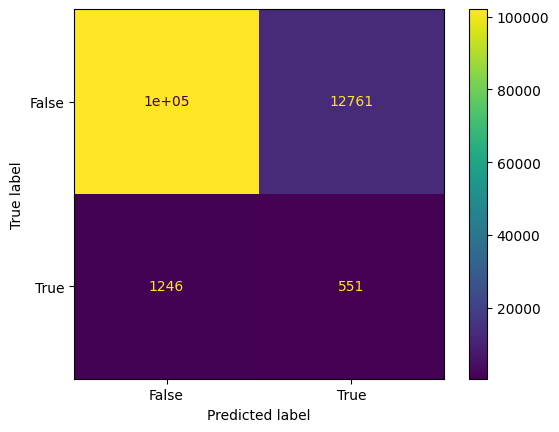

In [51]:
m7_test_results  = test_metrics(model_7, x_test_scaled, y_test)

## Model 8
Testing basic model architecture with biasas in fully connected layers

In [52]:
np.random.seed(33)
tf.random.set_seed(33)

model_8 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],), use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [53]:
model_8.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [54]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_8.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1094 - binary_accuracy: 0.9598 - recall_7: 0.9389 - precision_5: 0.9797 - val_loss: 0.7522 - val_binary_accuracy: 0.7306 - val_recall_7: 0.5298 - val_precision_5: 0.0302
Epoch 2/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.0799 - binary_accuracy: 0.9727 - recall_7: 0.9559 - precision_5: 0.9892 - val_loss: 0.9415 - val_binary_accuracy: 0.6909 - val_recall_7: 0.5637 - val_precision_5: 0.0279
Epoch 3/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.0730 - binary_accuracy: 0.9755 - recall_7: 0.9606 - precision_5: 0.9902 - val_loss: 1.3420 - val_binary_accuracy: 0.5937 - val_recall_7: 0.6494 - val_precision_5: 0.0244
Epoch 4/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.0686 - binary_accuracy: 0.9775 - recall_7: 0.9635 - precision_5: 0.9912 - val_loss: 1.1633 - val_binary_accuracy: 0.6169 - val_recall_7: 0.6160 - val_precision_5: 0.0

3644/3644 [==============================] - 2s 594us/step
Best Threshold: 0.98989898989899
Accuracy: 0.8307862509004836
Precision: 0.03130880200710851
Recall: 0.3333333333333333
F1-Score: 0.05724114864542023
AUC: 0.6728968898513712
Confusion Matrix:
[[96274 18533]
 [ 1198   599]]


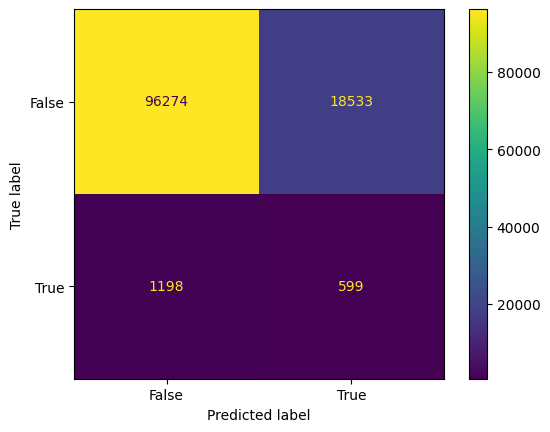

In [55]:
m8_test_results = test_metrics(model_8, x_test_scaled, y_test)

## Model 9
Using Model 5 architecture with bias

In [62]:
np.random.seed(33)
tf.random.set_seed(33)

model_9 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [63]:
model_9.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [64]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_9.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.1468 - binary_accuracy: 0.9424 - recall_9: 0.9177 - precision_7: 0.9654 - val_loss: 0.2375 - val_binary_accuracy: 0.9072 - val_recall_9: 0.2922 - val_precision_7: 0.0521
Epoch 2/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1098 - binary_accuracy: 0.9598 - recall_9: 0.9386 - precision_7: 0.9803 - val_loss: 0.2084 - val_binary_accuracy: 0.9215 - val_recall_9: 0.2554 - val_precision_7: 0.0555
Epoch 3/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1042 - binary_accuracy: 0.9622 - recall_9: 0.9417 - precision_7: 0.9819 - val_loss: 0.2503 - val_binary_accuracy: 0.9016 - val_recall_9: 0.2972 - val_precision_7: 0.0497
Epoch 4/10
33486/33486 [==============================] - 35s 1ms/step - loss: 0.1003 - binary_accuracy: 0.9642 - recall_9: 0.9442 - precision_7: 0.9836 - val_loss: 0.2335 - val_binary_accuracy: 0.9157 - val_recall_9: 0.2621 - val_precision_7: 0.0

3644/3644 [==============================] - 2s 564us/step
Best Threshold: 0.8080808080808082
Accuracy: 0.9355339439470344
Precision: 0.056451612903225805
Recall: 0.2025598219254313
F1-Score: 0.08829593693147363
AUC: 0.722793661030763
Confusion Matrix:
[[108723   6084]
 [  1433    364]]


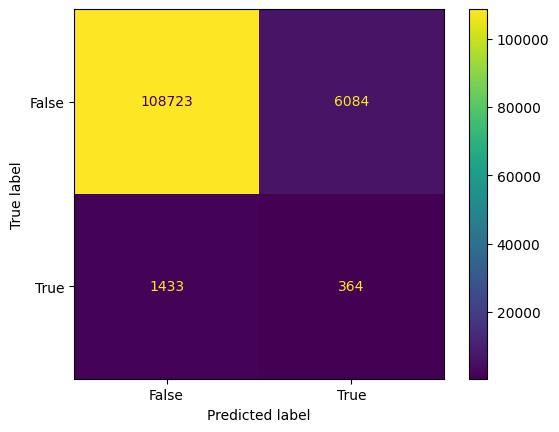

In [66]:
m9_test_results = test_metrics(model_9, x_test_scaled, y_test)

## Model 10
Same structure as 9 but with leaky relu instead

In [84]:
np.random.seed(33)
tf.random.set_seed(33)

model_10 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [85]:
model_10.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [86]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_10.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.1559 - binary_accuracy: 0.9380 - recall_12: 0.9105 - precision_9: 0.9635 - val_loss: 0.1942 - val_binary_accuracy: 0.9324 - val_recall_12: 0.2254 - val_precision_9: 0.0588
Epoch 2/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.1259 - binary_accuracy: 0.9519 - recall_12: 0.9282 - precision_9: 0.9744 - val_loss: 0.1860 - val_binary_accuracy: 0.9318 - val_recall_12: 0.2426 - val_precision_9: 0.0620
Epoch 3/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.1201 - binary_accuracy: 0.9548 - recall_12: 0.9328 - precision_9: 0.9758 - val_loss: 0.2459 - val_binary_accuracy: 0.9005 - val_recall_12: 0.3244 - val_precision_9: 0.0531
Epoch 4/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.1176 - binary_accuracy: 0.9559 - recall_12: 0.9343 - precision_9: 0.9765 - val_loss: 0.2587 - val_binary_accuracy: 0.8951 - val_recall_12: 0.3200 - val_precisio

3644/3644 [==============================] - 2s 555us/step
Best Threshold: 0.7676767676767677
Accuracy: 0.961202017083462
Precision: 0.07773304428615671
Recall: 0.13967723984418476
F1-Score: 0.09988062077198567
AUC: 0.7350237602552829
Confusion Matrix:
[[111829   2978]
 [  1546    251]]


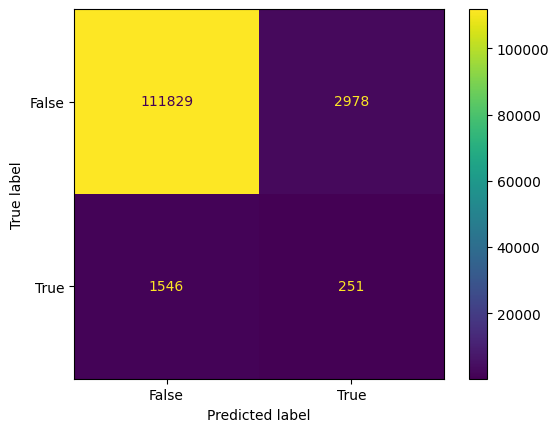

In [87]:
m10_test_results = test_metrics(model_10, x_test_scaled, y_test)

## Model 11


## Results ordering

In [88]:
all_results = {
    'model_1': m1_test_results,
    'model_2': m2_test_results,
    'model_3': m3_test_results,
    'model_4': m4_test_results,
    'model_5': m5_test_results,
    'model_6': m6_test_results,
    'model_7': m7_test_results,
    'model_8': m8_test_results,
    'model_9': m9_test_results,
    'model_10': m10_test_results,
}

In [89]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df

,Best Threshold,Accuracy,Precision,Recall,F1-Score,AUC,Confusion Matrix
model_1,0.070707,0.953569,0.094598,0.234836,0.134867,0.792098,"[[110768, 4039], [1375, 422]]"
model_2,0.989899,0.829628,0.032932,0.354480,0.060265,0.678811,"[[96101, 18706], [1160, 637]]"
model_3,0.989899,0.832356,0.035873,0.381747,0.065583,0.689203,"[[96370, 18437], [1111, 686]]"
model_4,0.000000,0.015411,0.015411,1.000000,0.030354,0.500000,"[[0, 114807], [0, 1797]]"
model_5,0.858586,0.955945,0.061680,0.130774,0.083824,0.718786,"[[111232, 3575], [1562, 235]]"
model_6,0.989899,0.860091,0.033005,0.285476,0.059170,0.677153,"[[99777, 15030], [1284, 513]]"
model_7,0.989899,0.879875,0.041391,0.306622,0.072937,0.703420,"[[102046, 12761], [1246, 551]]"
model_8,0.989899,0.830786,0.031309,0.333333,0.057241,0.672897,"[[96274, 18533], [1198, 599]]"
model_9,0.808081,0.935534,0.056452,0.202560,0.088296,0.722794,"[[108723, 6084], [1433, 364]]"
model_10,0.767677,0.961202,0.077733,0.139677,0.099881,0.735024,"[[111829, 2978], [1546, 251]]"


In [90]:
sorted_df = results_df.sort_values(by='F1-Score', ascending=False)
sorted_df

,Best Threshold,Accuracy,Precision,Recall,F1-Score,AUC,Confusion Matrix
model_1,0.070707,0.953569,0.094598,0.234836,0.134867,0.792098,"[[110768, 4039], [1375, 422]]"
model_10,0.767677,0.961202,0.077733,0.139677,0.099881,0.735024,"[[111829, 2978], [1546, 251]]"
model_9,0.808081,0.935534,0.056452,0.202560,0.088296,0.722794,"[[108723, 6084], [1433, 364]]"
model_5,0.858586,0.955945,0.061680,0.130774,0.083824,0.718786,"[[111232, 3575], [1562, 235]]"
model_7,0.989899,0.879875,0.041391,0.306622,0.072937,0.703420,"[[102046, 12761], [1246, 551]]"
model_3,0.989899,0.832356,0.035873,0.381747,0.065583,0.689203,"[[96370, 18437], [1111, 686]]"
model_2,0.989899,0.829628,0.032932,0.354480,0.060265,0.678811,"[[96101, 18706], [1160, 637]]"
model_6,0.989899,0.860091,0.033005,0.285476,0.059170,0.677153,"[[99777, 15030], [1284, 513]]"
model_8,0.989899,0.830786,0.031309,0.333333,0.057241,0.672897,"[[96274, 18533], [1198, 599]]"
model_4,0.000000,0.015411,0.015411,1.000000,0.030354,0.500000,"[[0, 114807], [0, 1797]]"


## RNN Model
First attempt with a simple architecture.

In [56]:

embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [57]:
model_r1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [58]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_r1.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_8/embedding/embedding_lookup' defined at (most recent call last):
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\brian\AppData\Local\Temp\ipykernel_41352\3956798898.py", line 4, in <module>
      history = model_r1.fit(x_train_scaled, y_train_resampled,
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_8/embedding/embedding_lookup'
indices[21,8] = -1 is not in [0, 500000)
	 [[{{node sequential_8/embedding/embedding_lookup}}]] [Op:__inference_train_function_16503013]

In [ ]:
test_metrics(model_r1, x_test_scaled, y_test)